In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from tqdm.autonotebook import tqdm

import Functions as F


In [2]:
Events, EvNumbers, HitsNum = [], [], []

data_file = "../data_merged/calibration/Run000260.txt"
tot_ev = 0
with open(data_file) as f:
    tot_ev = len(list(f))
with open(data_file) as f:
    with tqdm(total=tot_ev) as pbar:
        for line in f:
            ev, evNum, hits = F.Read_Data(line)
            Events.append(ev)
            EvNumbers.append(evNum)
            HitsNum.append(hits)
            pbar.update()

100%|██████████| 8182/8182 [00:08<00:00, 978.77it/s]


(array([5.608e+03, 1.989e+03, 2.910e+02, 1.380e+02, 6.700e+01, 4.400e+01,
        1.800e+01, 1.500e+01, 9.000e+00, 3.000e+00]),
 array([ 0. ,  7.8, 15.6, 23.4, 31.2, 39. , 46.8, 54.6, 62.4, 70.2, 78. ]),
 <a list of 10 Patch objects>)

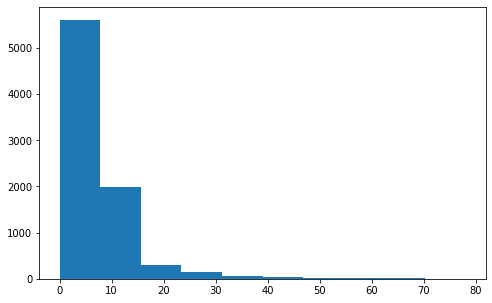

In [3]:
# histogram with the distribution of hits numbers
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(HitsNum)

In [4]:
ev    = Events[3]
evNum = EvNumbers[3]
hit   = HitsNum[3]
display(ev)


,EvNumber,Hit,Chamber,Layer,XL_local,XR_local,Z_local,Time,XL_global,XR_global,Z_global
0,4,0,0,1,650.100,651.90,6.5,15.8,344.100,342.30,830.0
1,4,1,2,2,165.800,170.20,19.5,41.7,-433.200,-437.60,843.0
2,4,2,2,4,160.600,175.40,45.5,137.5,-428.000,-442.80,869.0
3,4,3,2,1,127.700,166.30,6.5,359.2,-395.100,-433.70,830.0
4,4,4,2,3,131.800,162.20,32.5,282.5,-399.200,-429.60,856.0
5,4,5,3,2,40.560,43.44,19.5,26.7,-302.060,-304.94,19.5
6,4,6,3,1,13.950,28.05,6.5,130.8,-275.450,-289.55,6.5
7,4,7,3,4,35.310,48.69,45.5,124.2,-296.810,-310.19,45.5
8,4,8,3,3,18.530,23.47,32.5,45.8,-280.030,-284.97,32.5
9,4,9,3,2,25.940,58.06,19.5,298.3,-287.440,-319.56,19.5


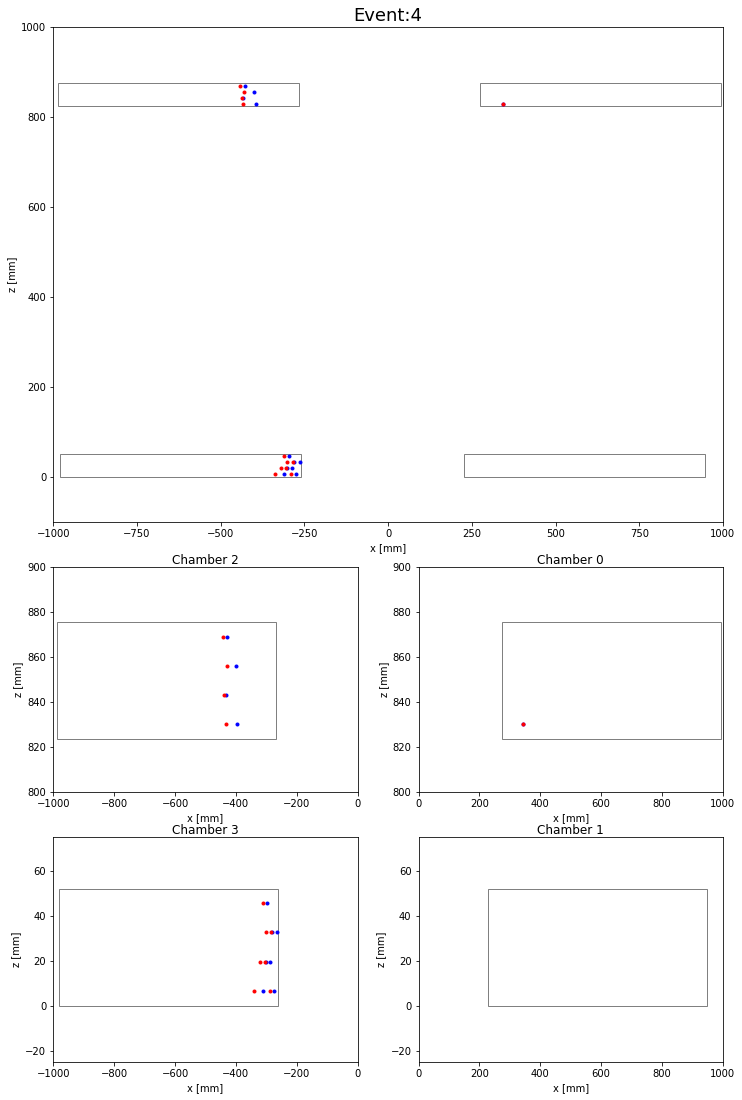

In [5]:
F.Make_Plot(ev, evNum)

In [6]:
condition, chambers, n_layers= F.Select_Events_Calibration(ev, evNum)
print(condition)

False
